In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet50
import torch.nn.functional as F
from torch import nn
from torch import optim

import json
import os
import time

## Load Training/Test Data

In [2]:
from os.path import exists

if not exists('original') :
  !wget -qO mixed_next.tar.gz https://www.dropbox.com/s/4hnkbvxastpcgz2/mixed_next.tar.gz?dl=0
  !wget -qO mixed_rand.tar.gz https://www.dropbox.com/s/cto15ceadgraur2/mixed_rand.tar.gz?dl=0
  !wget -qO mixed_same.tar.gz https://www.dropbox.com/s/f2525w5aqq67kk0/mixed_same.tar.gz?dl=0
  !wget -qO only_fg.tar.gz https://www.dropbox.com/s/alrf3jo8yyxzyrn/only_fg.tar.gz?dl=0
  !wget -qO original.tar.gz https://www.dropbox.com/s/0vv2qsc4ywb4z5v/original.tar.gz?dl=0
  
  !tar -xf 'mixed_next.tar.gz'
  !tar -xf 'mixed_rand.tar.gz'
  !tar -xf 'mixed_same.tar.gz'
  !tar -xf 'only_fg.tar.gz'
  !tar -xf 'original.tar.gz'


## Show image

In [3]:
preprocess = transforms.Compose([
  transforms.Resize(256), 
  transforms.CenterCrop(224), 
  transforms.ToTensor(), 
  transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
  )])

trainset_original = ImageFolder('./original/train', transform=preprocess)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  00_dog 0


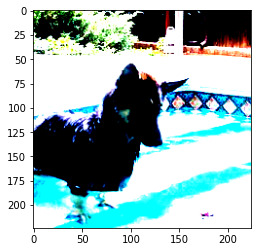

In [4]:

import matplotlib.pyplot as plt

def show_example(img, label, dataset):
    print('Label: ', dataset.classes[label], label)
    plt.imshow(img.permute(1, 2, 0)) 

show_example(*trainset_original[3500], trainset_original) 


In [5]:
trainset_original.classes


['00_dog',
 '01_bird',
 '02_wheeled vehicle',
 '03_reptile',
 '04_carnivore',
 '05_insect',
 '06_musical instrument',
 '07_primate',
 '08_fish']

## ResNet18

In [6]:
# Step1: initialize model
from torchvision.models import resnet18

model_18 = resnet18(pretrained=True)
model_18.avgpool = nn.AdaptiveAvgPool2d((1,1))
model_18.fc = nn.Linear(512, len(trainset_original.classes))


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [7]:
# Step2: Freeze layers by not tracking gradients
for param in model_18.parameters():
    param.requires_grad = False

model_18.fc.weight.requires_grad = True # unfreeze last layer weights
model_18.fc.bias.requires_grad = True #unfreeze last layer biases


In [8]:

# Step3: 
batch_size=64

data_transforms = {
    'original/train': transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
    'original/val': transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'mixed_next/val':transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'mixed_rand/val':transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'mixed_same/val':transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'only_fg/val':transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: ImageFolder('./'+x, data_transforms[x]) for x in ['original/train', 'original/val', 'mixed_next/val', 'mixed_rand/val', 'mixed_same/val', 'only_fg/val', 'original/val'] }

# Create training and validation dataloaders
dataloaders_dict = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['original/train', 'original/val', 'mixed_next/val', 'mixed_rand/val', 'mixed_same/val', 'only_fg/val', 'original/val'] }



Initializing Datasets and Dataloaders...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:

# Step3: create optimizer
optimiser = optim.Adam(filter(lambda p: p.requires_grad, model_18.parameters()), lr=1e-4) #only optimse non-frozen layers

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()


In [10]:
# https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/finetuning_torchvision_models_tutorial.ipynb
# https://www.kaggle.com/frozenwolf/coronahack-finetuning-resnet18-pytorch
import matplotlib.pyplot as plt
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    since = time.time()

    original_train_acc_history = []
    original_val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['original/train', 'original/val']:
            if phase == 'original/train':
                model.train()  # Set model to training mode
            else:
               model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'original/train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'original/train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'original/val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'original/train':
                original_train_acc_history.append(epoch_acc)

            if phase == 'original/val':
                original_val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, original_train_acc_history, original_val_acc_history


In [11]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_18 = model_18.to(device)


# Number of epochs to train for 
num_epochs = 2


# Train and evaluate
model_18, original_train_acc_history, original_val_acc_history= train_model(model_18, 
                                                           dataloaders_dict, 
                                                           criterion, 
                                                           optimiser, 
                                                           num_epochs=num_epochs)


Epoch 0/1
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


original/train Loss: 0.9741 Acc: 0.7864
original/val Loss: 0.4265 Acc: 0.9231

Epoch 1/1
----------
original/train Loss: 0.3274 Acc: 0.9353
original/val Loss: 0.2688 Acc: 0.9360

Training complete in 10m 41s
Best val Acc: 0.935962


### Test Accuracy

In [13]:
def evaluation(model_ft, dataloader):
  model_ft.eval()
  test_corrects = 0
  for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    test_corrects += torch.sum(preds == labels.data)
  acc = test_corrects.double() / len(dataloader.dataset)
  print(acc)
  return acc.item()


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor(0.6143, device='cuda:0', dtype=torch.float64)
tensor(0.6628, device='cuda:0', dtype=torch.float64)
tensor(0.8401, device='cuda:0', dtype=torch.float64)
tensor(0.7983, device='cuda:0', dtype=torch.float64)
tensor(0.9360, device='cuda:0', dtype=torch.float64)


<BarContainer object of 5 artists>

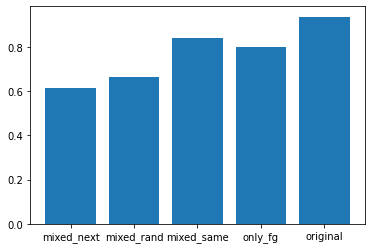

In [14]:
test_sets = ['mixed_next', 'mixed_rand', 'mixed_same', 'only_fg', 'original']
test_acc = []

for name in test_sets:
  test_acc.append(evaluation(model_18, dataloaders_dict[name + '/val']))

import matplotlib.pyplot as plt
plt.bar(test_sets, test_acc)
